# HBV hydrological model forced with ERA5 forcing data
In this notebook we will generate forcing data for the HBV hydrological model from the ERA5 dataset and from a historical CMIP dataset (ie output of a climate model when run for a period of time that represents part of history, not a future prediction). 

We use the forcing module of the eWaterCycle platform to easily generate this data. 

Later on this forcing will be used to both calibrate and run the HBV hydrological model and produce estimates of river discharge.

In [1]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import json
from esmvalcore.config import CFG

# Niceties
from rich import print

In [2]:
# General eWaterCycle
import ewatercycle
import ewatercycle.forcing

In [3]:
# Parameters
region_id = None
settings_path = "settings.json"

In [4]:
# Parameters
region_id = "camelsgb_22009"
settings_path = "regions/camelsgb_22009/settings.json"


In [5]:
# Load settings
# Read from the JSON file
with open(settings_path, "r") as json_file:
    settings = json.load(json_file)

In [6]:
display(settings)

{'caravan_id': 'camelsgb_22009',
 'calibration_start_date': '1994-08-01T00:00:00Z',
 'calibration_end_date': '2004-07-31T00:00:00Z',
 'validation_start_date': '2004-08-01T00:00:00Z',
 'validation_end_date': '2014-07-31T00:00:00Z',
 'future_start_date': '2029-08-01T00:00:00Z',
 'future_end_date': '2049-08-31T00:00:00Z',
 'CMIP_info': {'dataset': ['MPI-ESM1-2-HR'],
  'ensembles': ['r1i1p1f1'],
  'experiments': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
  'project': 'CMIP6',
  'frequency': 'day',
  'grid': 'gn',
  'variables': ['pr', 'tas', 'rsds']},
 'base_path': '/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV',
 'path_caravan': '/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/forcing_data/camelsgb_22009/caravan',
 'path_ERA5': '/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/forcing_data/camelsgb_22009/ERA5',
 'path_CMIP6': '/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/forcing_data/camelsgb_22009/CMIP6',
 'path_output': '/

## Generate or load forcing
When generating forcing using eWaterCycle there are two important choices to make: dataset that the data comes from and type of forcing that the model requires. The dataset in this example is ERA5. The HBV model in eWaterCycle needs potential evaporation data. Both the 'caravan' type forcing as well as the 'LumpedMakkinkForcing' provide potential evaporation. Note that the 'caravan' type forcing only works with the 'caravan' dataset as well, so here we select 'ERA5 for the dataset and LumpedMakkinkForcing for the type.

Note that ERA5 data needs to be stored on the system you are working on. For SURF Research Cloud machines running the eWaterCycle catalog item, this is handled by the eWaterCycle team. 

More complex models often require their own type of forcing, for example the wflow model requires 'wflow' type forcing specifically designed for that model, but this is not the case for HBV in eWaterCycle.

In [7]:
# Generate forcing:
try:
    load_location = Path(settings['path_ERA5']) / "work" / "diagnostic" / "script" 
    ERA5_forcing_object = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)
except:    
    ERA5_forcing_object = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
       dataset="ERA5",
       start_time=settings['calibration_start_date'],
       end_time=settings['validation_end_date'],
       directory=settings['path_ERA5'],
       shape=settings['path_shape'],
    )

In [8]:
display(ERA5_forcing_object)

LumpedMakkinkForcing(start_time='1994-08-01T00:00:00Z', end_time='2014-07-31T00:00:00Z', directory=PosixPath('/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/forcing_data/camelsgb_22009/ERA5/work/diagnostic/script'), shape=PosixPath('/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/forcing_data/camelsgb_22009/ERA5/work/diagnostic/script/camelsgb_22009.shp'), filenames={'pr': 'OBS6_ERA5_reanaly_1_day_pr_1994-2014.nc', 'tas': 'OBS6_ERA5_reanaly_1_day_tas_1994-2014.nc', 'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_1994-2014.nc', 'evspsblpot': 'Derived_Makkink_evspsblpot.nc'})

/scratch-local/mmelotto.17159918/ipykernel_3371007/1279259822.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
/scratch-local/mmelotto.17159918/ipykernel_3371007/1279259822.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.


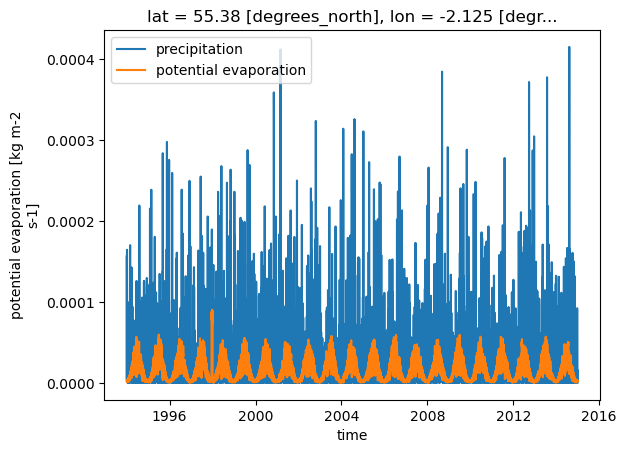

In [9]:
# Quick plot of the precipitation and potential evaporation data
ds_ERA5 = xr.open_mfdataset([ERA5_forcing_object['pr'],ERA5_forcing_object['evspsblpot']])
ds_ERA5["pr"].plot(label = 'precipitation')
ds_ERA5["evspsblpot"].plot(label = 'potential evaporation')
plt.legend()

## CMIP historical forcing
While ERA5 data is hosted by the eWaterCycle team on SURF Research Cloud Machines, data from CMIP is downloaded 'on the fly' when requested. 

In [10]:
display(settings['CMIP_info'])

{'dataset': ['MPI-ESM1-2-HR'],
 'ensembles': ['r1i1p1f1'],
 'experiments': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
 'project': 'CMIP6',
 'frequency': 'day',
 'grid': 'gn',
 'variables': ['pr', 'tas', 'rsds']}

In [11]:
# Setting for ESMValTool to make sure the online esgf resources are always used and
# we don't rely on locally cached information.
# CFG['search_esgf'] = 'when_missing'
CFG['search_esgf'] = 'always'
CFG['rootpath'] = {'CMIP6': [Path(settings['path_CMIP6'])], 'default': [Path(settings['path_output'])]}
CFG['download_dir'] = settings['downloads']
print(CFG)

auxiliary_data_dir: /home/mmelotto/auxiliary_data
check_level: 3
compress_netcdf: False
config_developer_file: 
/home/mmelotto/.conda/envs/ewatercycle_snellius/lib/python3.12/site-packages/esmvalcore/config-developer.yml
config_file: 
/home/mmelotto/.conda/envs/ewatercycle_snellius/lib/python3.12/site-packages/esmvalcore/config-user.yml
diagnostics: None
download_dir: /gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/downloads/camelsgb_22009
drs: {'CMIP3': 'ESGF', 'CMIP5': 'ESGF', 'CMIP6': 'ESGF', 'CORDEX': 'ESGF', 'obs4MIPs': 'ESGF'}
exit_on_warning: False
extra_facets_dir: ()
log_level: info
max_datasets: None
max_parallel_tasks: None
max_years: None
output_dir: /home/mmelotto/esmvaltool_output
output_file_type: png
profile_diagnostic: False
remove_preproc_dir: True
resume_from: []
rootpath: {'CMIP6': 
[PosixPath('/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/forcing_data/camelsgb_22009/CMIP6')], 
'default': [PosixPath('/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/output_data/camelsgb_22009')]}
run_diagnostic: True
save_intermediary_cubes: False
search_esgf: always
skip_nonexistent: False

In [12]:
display(CFG)

Config({'auxiliary_data_dir': PosixPath('/home/mmelotto/auxiliary_data'),
        'check_level': <CheckLevels.DEFAULT: 3>,
        'compress_netcdf': False,
        'config_developer_file': PosixPath('/home/mmelotto/.conda/envs/ewatercycle_snellius/lib/python3.12/site-packages/esmvalcore/config-developer.yml'),
        'config_file': PosixPath('/home/mmelotto/.conda/envs/ewatercycle_snellius/lib/python3.12/site-packages/esmvalcore/config-user.yml'),
        'diagnostics': None,
        'download_dir': PosixPath('/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/downloads/camelsgb_22009'),
        'drs': {'CMIP3': 'ESGF',
                'CMIP5': 'ESGF',
                'CMIP6': 'ESGF',
                'CORDEX': 'ESGF',
                'obs4MIPs': 'ESGF'},
        'exit_on_warning': False,
        'extra_facets_dir': (),
        'log_level': 'info',
        'max_datasets': None,
        'max_parallel_tasks': None,
        'max_years': None,
        'output_dir': PosixPath('/ho

I loop over the datasets and ensemble members to facilitate running this notebook for multiple climate models ('datasets') and ensemble members. If this is required, this needs to be changed in the settings specified in [notebook 0a](step_0a_select_caravan_region_time_and_scenarios.ipynb). This notebook would not have to be changed for this.

In [13]:
for dataset in settings['CMIP_info']['dataset']:

    for ensemble_member in settings['CMIP_info']['ensembles']:

        cmip_dataset = {
            "dataset": dataset,
            "project": settings['CMIP_info']['project'],
            "grid": "gn",
            "exp": "historical",
            "ensemble": ensemble_member,
        }

        print(cmip_dataset)

        # Create a subfolder for this specific combination of dataset, experiment and ensemblemember
        path_CMIP6 = Path(settings['path_CMIP6']) / cmip_dataset["dataset"] / cmip_dataset["exp"] / cmip_dataset["ensemble"]
        path_CMIP6.mkdir(exist_ok=True, parents=True)

        # Generate forcing:
        try:
            load_location = path_CMIP6 / "work" / "diagnostic" / "script" 
            CMIP_forcing_object = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)
        except:
            CMIP_forcing_object = ewatercycle.forcing.sources["LumpedMakkinkForcing"].generate(
               dataset=cmip_dataset,
               start_time=settings['calibration_start_date'],
               end_time=settings['validation_end_date'],
               directory=path_CMIP6,
               shape=settings['path_shape'],
            )
            
        print(CMIP_forcing_object)

{'dataset': 'MPI-ESM1-2-HR', 'project': 'CMIP6', 'grid': 'gn', 'exp': 'historical', 'ensemble': 'r1i1p1f1'}

LumpedMakkinkForcing(
    start_time='1994-08-01T00:00:00Z',
    end_time='2014-07-31T00:00:00Z',
    directory=PosixPath('/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/forcing_data/camelsgb_22009/CM
IP6/MPI-ESM1-2-HR/historical/r1i1p1f1/work/diagnostic/script'),
    shape=PosixPath('/gpfs/scratch1/shared/mmelotto/ewatercycleClimateImpact/HBV/forcing_data/camelsgb_22009/CMIP6/
MPI-ESM1-2-HR/historical/r1i1p1f1/work/diagnostic/script/camelsgb_22009.shp'),
    filenames={
        'pr': 'CMIP6_MPI-ESM1-2-HR_day_historical_r1i1p1f1_pr_gn_1994-2014.nc',
        'tas': 'CMIP6_MPI-ESM1-2-HR_day_historical_r1i1p1f1_tas_gn_1994-2014.nc',
        'rsds': 'CMIP6_MPI-ESM1-2-HR_day_historical_r1i1p1f1_rsds_gn_1994-2014.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

/scratch-local/mmelotto.17159918/ipykernel_3371007/2825575744.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
/scratch-local/mmelotto.17159918/ipykernel_3371007/2825575744.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.


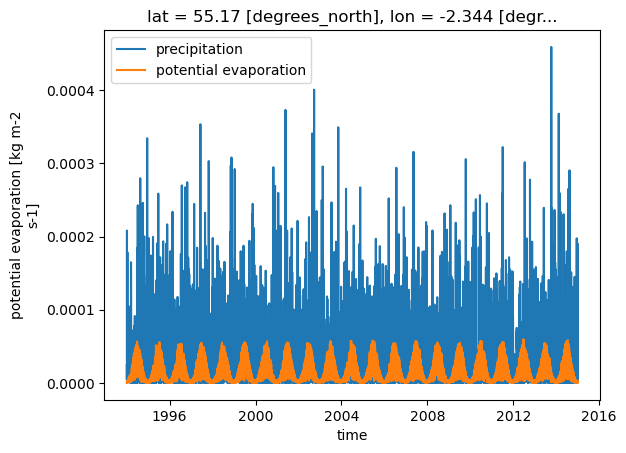

In [14]:
# Quick plot of the precipitation and potential evaporation data of the last generated forcing
ds_CMIP = xr.open_mfdataset([CMIP_forcing_object['pr'],CMIP_forcing_object['evspsblpot']])
ds_CMIP["pr"].plot(label = 'precipitation')
ds_CMIP["evspsblpot"].plot(label = 'potential evaporation')
plt.legend()